# Image Segmentation Task 2

In [ ]:
!python -m pip install cityscapesscripts

### Imports

In [1]:
import os
import torch
import random
import zipfile
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

from importlib import reload
from utils import EarlyStopping
from os.path import join as pjoin
from torchvision import transforms
from networks.r2unet import R2UNet16, R2UNet64
from datasets.cityscapes import cityscapesDataset

### Setup

In [2]:
# reproducibility setups
torch.manual_seed(253452757)
random.seed(253452757)
np.random.seed(253452757)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="6" 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Hyperparameters

In [4]:
local_path = "./Cityscapes"
bs = 5
epochs = 16
learning_rate = 0.0002
patience = 10

### Dataset and Dataloader

In [5]:
training_data = cityscapesDataset(local_path, split="train")
validation_data = cityscapesDataset(local_path, split="val")
test_data = cityscapesDataset(local_path, split="test")

Annotations files processed
Annotations files processed
Annotations files processed


In [6]:
dataloaders = {
    'train' : torch.utils.data.DataLoader(training_data, batch_size=bs, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(validation_data, batch_size=bs, shuffle=True, num_workers=0)
}

In [7]:
dataset_sizes = {
    'train': len(training_data),
    'val': len(validation_data),
    'test': len(test_data),
    'total': len(training_data) + len(validation_data) + len(test_data)
}

dataset_sizes

{'train': 2975, 'val': 500, 'test': 1525, 'total': 5000}

### Model setup

In [8]:
model = R2UNet64().to(device)


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_f = nn.CrossEntropyLoss(ignore_index = 255)

### Training

In [ ]:
model_path = 'models2/r2unet64/'
if not os.path.isdir(model_path):
    os.makedirs(model_path)

In [ ]:
model = training.train_early_stopping(model, dataloaders, dataset_sizes, model_path, loss_f, optimizer)

In [11]:
checkpoint = torch.load(pjoin(model_path, "best_model.pt"))

In [12]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Evaluate the results

In [17]:
import evaluation

In [18]:
true_list = []
pred_list = []
model.eval()
model = model.to(device)

with torch.no_grad():
    for inputs, ground_truths in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        pred_list.append(torch.argmax(outputs.detach().cpu(), dim = 1))
        true_list.append(ground_truths)

true_list = torch.flatten(torch.cat(true_list))
pred_list = torch.flatten(torch.cat(pred_list))

In [19]:
eval_report = evaluation.EvaluationReport.from_predictions(true_list, pred_list, labels=list(range(19)))

In [20]:
eval_report.get_metrics(average="macro")

{'accuracy': 0.9553,
 'sensitivity': 0.3202,
 'specificity': 0.97,
 'dice_coeff': 0.2442,
 'jaccard_sim': 0.1683,
 'f1_score': 0.2442}

### Visualize the results

In [13]:
from utils import plot_seg_results
import importlib

In [14]:
dataloader = torch.utils.data.DataLoader(validation_data, batch_size=5, shuffle=True, num_workers=0)
images, ground_truths = next(iter(dataloader))
outputs = model(images.to(device))
predictions = torch.argmax(outputs.squeeze().cpu(), dim = 1)

In [15]:
images = [img.permute(1, 2, 0).numpy() for img in images]
predictions = [validation_data.decode_segmap(pred.numpy()) for pred in predictions]
ground_truths = [validation_data.decode_segmap(gt.numpy()) for gt in ground_truths]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


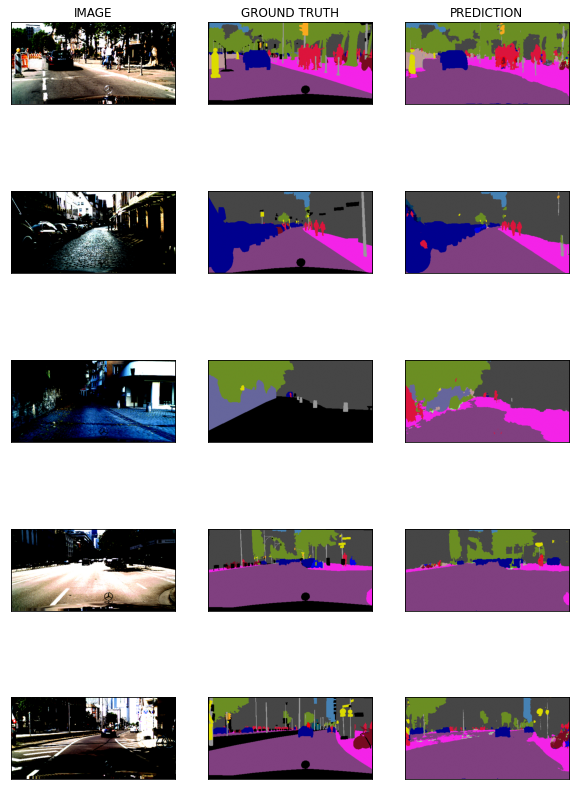

In [16]:
plot_seg_results(images, ground_truths, predictions)